# On-Cloud Data Retrieval and Analysis: Aboveground biomass from GEDI, ICESat-2 and Field Data
## Overview
This tutorial will demonstrate how to directly access and retrieve the GEDI dataset, ICESat-2 and Field Data in the cloud.

In [1]:
import h5py
import earthaccess
import s3fs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from harmony import BBox, Client, Collection, Request, LinkType
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set(style='whitegrid')

## Area of interest
We will use a boundary of the [Reserva Florestal Adolpho Ducke](https://ppbio.inpa.gov.br/en/Sites/RFAD), as the region of interest. Reserva Adolpho Ducke is a 10,000-hectare (25,000-acre) protected area of the Amazon rainforest on the outskirts of the city of Manaus, Brazil. It is a part of long term ecological research network and is one of the most intensively studied rainforest in the world.

The boundary file is provided as a GeoJSON file at `polygons/reserva_ducke.json`. Let’s open and plot this file. 

In [2]:
# esri background basemap for maps
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"
poly_json = 'polygons/reserva_ducke.json'
poly = gpd.read_file(poly_json) 
poly.explore(color='red', fill=False, tiles=xyz, attr=attr)

## Datasets
- Dubayah, R.O., J. Armston, J.R. Kellner, L. Duncanson, S.P. Healey, P.L. Patterson, S. Hancock, H. Tang, J. Bruening, M.A. Hofton, J.B. Blair, and S.B. Luthcke. 2022. GEDI L4A Footprint Level Aboveground Biomass Density, Version 2.1. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2056
- Neuenschwander, A. L., Pitts, K. L., Jelley, B. P., Robbins, J., Markel, J., Popescu, S. C., Nelson, R. F., Harding, D., Pederson, D., Klotz, B. & Sheridan, R. (2023). ATLAS/ICESat-2 L3A Land and Vegetation Height. (ATL08, Version 6). Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/ATLAS/ATL08.006.
- dos-Santos, M.N., M.M. Keller, E.R. Pinage, and D.C. Morton. 2022. Forest Inventory and Biophysical Measurements, Brazilian Amazon, 2009-2018. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2007

## Workflow
```{mermaid}
erDiagram
    ORNL_DAAC {
        S3-bucket ornl-cumulus-prod-protected
    }
    NSIDC_DAAC {
        S3-bucket nsidc-cumulus-prod-protected
    }
    Forest_Inventory_Brazil {
        Instrument Field_Measurement
    }
    GEDI04_A {
        Instrument GEDI 
    }
    ATL08 {
        Instrument ICESaT-2
    }
    Harmony {
        Type Service
        S3-bucket harmony-prod-staging
    }
    Earthaccess {
        Type Tool
    }
    ORNL_DAAC||..||Forest_Inventory_Brazil: ""
    ORNL_DAAC||..||GEDI04_A: ""
    NSIDC_DAAC||..||ATL08: ""
    ATL08||..||Harmony: "trajectory subsetter"
    GEDI04_A||..||Harmony: "trajectory subsetter"
    Forest_Inventory_Brazil ||..||Earthaccess: "direct access"
    Harmony||--o{ "JupyterHub" : "direct access"
    Earthaccess||--o{ "JupyterHub" : "direct access"
```

## Earthdata Authentication
We recommend authenticating your Earthdata Login (EDL) information using the earthaccess python library as follows:

In [3]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## 1. Plot-level Forest Inventory Data
```{mermaid}
erDiagram
    ORNL_DAAC {
        S3-bucket ornl-cumulus-prod-protected
    }
    Forest_Inventory_Brazil {
        Instrument Field_Measurement
    }
    Earthaccess {
        Type Tool
    }
    ORNL_DAAC||..||Forest_Inventory_Brazil: ""
    Forest_Inventory_Brazil||..||Earthaccess: "direct access"
    Earthaccess||--o{ "JupyterHub" : "direct access"
```

### 1a. Search data files
We will use the `earthaccess` module to search for granules within the dataset {cite}`dossantos2022`.

In [4]:
# CMS Brazil field dataset
doi = '10.3334/ORNLDAAC/2007'
# searching files
granules = earthaccess.search_data(
    doi=doi, # dataset doi
    granule_name = "*.csv",
    bounding_box = tuple(poly.total_bounds.tolist()),
    cloud_hosted = True
)

In [5]:
# print s3 links
[g.data_links(access="direct")[0] for g in granules]

['s3://ornl-cumulus-prod-protected/cms/Forest_Inventory_Brazil/data/DUC_A01_2009_2011_Inventory.csv',
 's3://ornl-cumulus-prod-protected/cms/Forest_Inventory_Brazil/data/DUC_A01_2016_Inventory.csv']

Of the two datasets found, we will retrieve the 2016 inventory which is closer to the GEDI and ICESat-2 temporal range. The Forest Inventory Adolpho Ducke Forest Reserve II (DUC_A01_2016_Inventory) was carried out in Adolpho Ducke Forest Reserve, Amazonas, Brazil. A total of 17 50x50m plots were measured in 2016. Trees with diameter at breast height (DBH) equal to or greater than 35cm were accounted for and measured within the plot area whereas trees with DBH equal to or greater than 10cm were only measured within the subplot area.

### 1b. Open and plot the data file
Let's open the granule (s3 object) into a xarray. The `earthaccess` module manages temporary authentication needed for accessing data in NASA's Earthdata cloud.

In [6]:
for fh in earthaccess.open(granules):
    if fh.granule.data_links()[0].endswith("2016_Inventory.csv"):
        field_df = pd.read_csv(fh, encoding='latin-1')

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# printing the dataframe
field_df

,area,plot,tree,common.name,scientific.name,family.name,DBH,type,Dead,D.class,Htotc,date,UTM.Easting,UTM.Northing
0,DUC_A01,2,001a,macucu,Licania guianensis,Chrysobalanaceae,49.6,O,False,NaN,29.044534,20160824,-2.943539,-59.940809
1,DUC_A01,2,001b,uxirana,Sacoglottis guianensis,Humiriaceae,43.6,O,False,NaN,27.020845,20160824,-2.943568,-59.941062
2,DUC_A01,2,002a,mapatirana,Pourouma minor,Urticaceae,31.5,O,False,NaN,22.418301,20160824,-2.943542,-59.940815
3,DUC_A01,2,002b,abiurana,Pouteria gongrijpii,Sapotaceae,39.2,O,False,NaN,25.436839,20160824,-2.943623,-59.940967
4,DUC_A01,2,003a,roxinho,Peltogyne lecointei,Fabaceae,10.0,O,False,NaN,11.152521,20160824,-2.943536,-59.940822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,DUC_A01,20,048a,quarubarana,Erisma uncinatum,Vochysiaceae,24.0,O,False,NaN,19.091508,20160830,-2.941644,-59.941304
1165,DUC_A01,20,049a,fava saboeiro,Abarema jupunba,Fabaceae,14.0,O,False,NaN,13.754626,20160830,-2.941603,-59.941318
1166,DUC_A01,20,050a,mamorana,Eriotheca globosa,Malvaceae,22.0,O,False,NaN,18.121606,20160830,-2.941590,-59.941336
1167,DUC_A01,20,051a,louro cheiroso,Diospyros artanthifolia,Ebenaceae,11.9,O,False,NaN,12.434791,20160830,-2.941579,-59.941335


In [8]:
# plot tree locations on a map
field_gdf = gpd.GeoDataFrame(field_df, crs="EPSG:4326",
                       geometry=gpd.points_from_xy(field_df["UTM.Northing"],
                                                   field_df["UTM.Easting"]))
m = field_gdf.explore(column='plot', cmap='tab20', legend=None, tiles=xyz, attr=attr)
m

### 1c. Compute aboveground biomass
We will be using the allometry for the tropical forest from [Chave et al. 2005](https://doi.org/10.1007/s00442-005-0100-x) and wood specific gravity for central Amazon obtained from [Chave et al. 2006](https://doi.org/10.1890/1051-0761(2006)016[2356:RAPVOW]2.0.CO;2).

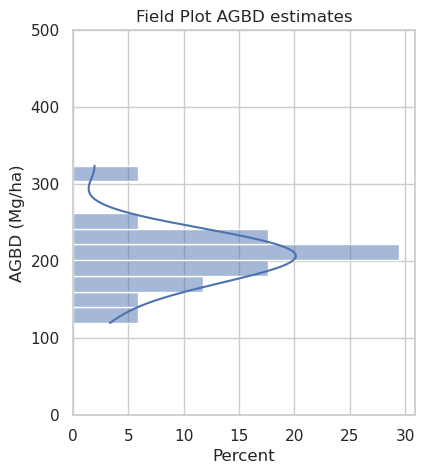

In [9]:
# applying allometry
field_df['AGB_kg']=0.0509*0.652*((field_df.DBH)**2)*(field_df.Htotc)
# computing total agb
total_agb = field_df.groupby(['plot'])['AGB_kg'].sum().reset_index()
# computing agbd in Mgha-1
total_agb['AGBD']=total_agb['AGB_kg']/(0.25*1000)
# plotting agbd

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
sns.histplot(ax=ax1, data=total_agb, y="AGBD", binwidth=20, kde=True, stat='percent')
ax1.set(ylabel="AGBD (Mg/ha)", 
       title=f"Field Plot AGBD estimates")
ax1.set(ylim=(0, 500))
plt.show()

## 2. GEDI L4A Biomass
```{mermaid}
erDiagram
    ORNL_DAAC {
        S3-bucket ornl-cumulus-prod-protected
    }
    GEDI04_A {
        Instrument GEDI 
    }
    Harmony {
        Type Service
        S3-bucket harmony-prod-staging
    }
    ORNL_DAAC||..||GEDI04_A: ""
    GEDI04_A||..||Harmony: "trajectory subsetter"
    Harmony||--o{ "JupyterHub" : "direct access"
```

### 2a. Define Harmony Request Parameters

Let’s create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A {cite}`dubayah2022` variables of interest and temporal range.

In [10]:
def create_gedi_vars(variables):
    # gedi beams
    beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
    # combine variables and beam names
    return [f'/{b}/{v}' for b in beams for v in variables]

# gedi variables
variables_l4a = create_gedi_vars(['agbd', 'l4_quality_flag', 'land_cover_data/pft_class'])

# bounding box
b = field_gdf.total_bounds
bounding_box = BBox(w=b[0], s=b[1], e=b[2], n=b[3])

### 2b. Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. 

In [11]:
doi = '10.3334/ORNLDAAC/2056' # GEDI L4A DOI

# harmony client
harmony_client = Client()
# concept id
concept_id = earthaccess.search_datasets(doi=doi, 
                                         cloud_hosted= True)[0].concept_id()
# define harmony collection
collection = Collection(id=concept_id)
# define harmony request
request = Request(collection=collection, 
              variables=variables_l4a, 
              spatial=bounding_box,
              ignore_errors=True)
# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)
# retrieve results in-region
results_l4a = harmony_client.result_urls(subset_job_id, 
                                         show_progress=True,
                                         link_type=LinkType.s3)

A temporary S3 Credentials is needed for read-only, same-region (`us-west-2`), direct access to S3 objects on the Earthdata cloud. We will use the credentials from the `harmony_client` and pass the credentials to [S3Fs class](https://s3fs.readthedocs.io/) S3FileSystem.

In [12]:
creds = harmony_client.aws_credentials()
s3 = s3fs.S3FileSystem(anon=False,
                       key=creds['aws_access_key_id'],
                       secret=creds['aws_secret_access_key'],
                       token=creds['aws_session_token'])

### 2c. Read Subset files
Let’s direct access the subsetted `h5` files and retrieve its values into the pandas dataframe.

In [13]:
def read_gedi_vars(beam):
    """reads through gedi variable hierarchy"""
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        # check if the item is a group
        if isinstance(value, h5py.Group):
            # looping through subgroups
            for key2, value2 in value.items():
                col_names.append(key2)
                col_val.append(value2[:].tolist())
        else:
            col_names.append(key)
            col_val.append(value[:].tolist())
    return col_names, col_val


# define an empty pandas dataframe
gedi_df = pd.DataFrame()
# loop through the Harmony results
for s3_url in results_l4a:
    with s3.open(s3_url, mode='rb') as fh:
        with h5py.File(fh) as hf:
            for v in list(hf.keys()):
                if v.startswith('BEAM'):
                    c_n, c_v = read_gedi_vars(hf[v])
                    # Appending to the subset_df dataframe
                    gedi_df = pd.concat([gedi_df, 
                                         pd.DataFrame(map(list, zip(*c_v)), columns=c_n)])

 [ Processing: 100% ] |###################################################| [|]


In [14]:
gedi_df

,agbd,delta_time,lat_lowestmode_a1,lon_lowestmode_a1,shot_number,l4_quality_flag,pft_class,shot_number,lat_lowestmode,lon_lowestmode,shot_number
0,220.623764,4.816986e+07,-2.939290,-59.927480,32860600400739984,1,2,32860600400739984,-2.939290,-59.927480,32860600400739984
0,159.050827,4.816986e+07,-2.939357,-59.937151,32860800400287888,1,2,32860800400287888,-2.939356,-59.937150,32860800400287888
1,305.318329,4.816986e+07,-2.939777,-59.936855,32860800400287889,1,2,32860800400287889,-2.939777,-59.936855,32860800400287889
2,254.206024,4.816986e+07,-2.940198,-59.936561,32860800400287890,1,2,32860800400287890,-2.940198,-59.936561,32860800400287890
3,328.749969,4.816986e+07,-2.940618,-59.936265,32860800400287891,1,2,32860800400287891,-2.940619,-59.936265,32860800400287891
...,...,...,...,...,...,...,...,...,...,...,...
18,301.810730,1.542895e+08,-2.955610,-59.928784,223300600100250298,1,2,223300600100250298,-2.955610,-59.928784,223300600100250298
19,214.981918,1.542895e+08,-2.955188,-59.928485,223300600100250299,1,2,223300600100250299,-2.955188,-59.928485,223300600100250299
20,151.302307,1.542895e+08,-2.954764,-59.928184,223300600100250300,1,2,223300600100250300,-2.954766,-59.928187,223300600100250300
21,310.973114,1.542895e+08,-2.954345,-59.927890,223300600100250301,1,2,223300600100250301,-2.954345,-59.927890,223300600100250301


### 2d. Quality Filter and Plot
We can now quality filter the dataset and only retrieve the good quality shots for trees and shrub cover plant functional types (PFTs).

In [15]:
# remove duplicate columns if any
gedi_df = gedi_df.loc[:,~gedi_df.columns.duplicated()].copy()
# converting to geojson
gedi_gdf = gpd.GeoDataFrame(gedi_df, 
                                geometry=gpd.points_from_xy(gedi_df.lon_lowestmode, 
                                                            gedi_df.lat_lowestmode),
                                crs="EPSG:4326")
# creating mask with good quality shots and trees/shrubs pft class
mask = (gedi_gdf['l4_quality_flag']==1) & (gedi_gdf['pft_class'] <= 5 )
# plotting
gedi_gdf = gedi_gdf[['lat_lowestmode', 'lon_lowestmode', 'pft_class', 'agbd', 'geometry']]
gedi_gdf[mask].explore("agbd", m=m, vmax=500, cmap = "YlGn", alpha=0.5, 
                       radius=10, legend=True)

As we see above, the PFT of the GEDI shots in the area is classed as `2` or "Evergreen Broadleaf Trees". We will plot the distribution of the AGBD for good quality shots.

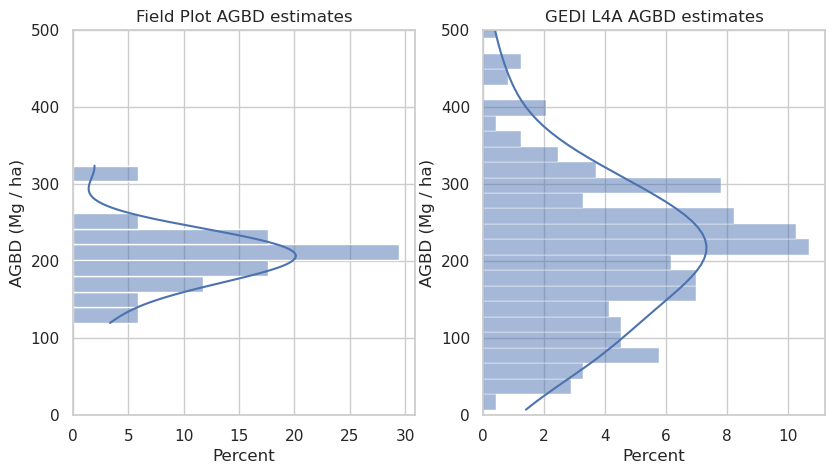

In [16]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
sns.histplot(ax=ax1, data=total_agb, y="AGBD", binwidth=20, kde=True, stat='percent')
ax1.set(ylabel="AGBD (Mg / ha)", ylim=(0, 500),
       title="Field Plot AGBD estimates")
ax2 = fig.add_subplot(1, 3, 2)
sns.histplot(ax=ax2, data=gedi_gdf[mask], binwidth=20, y="agbd", kde=True, stat='percent') 
ax2.set(ylabel="AGBD (Mg / ha)", ylim=(0, 500),
       title="GEDI L4A AGBD estimates")
plt.show()

## 3. ICESat-2 ATL08
```{mermaid}
erDiagram
    NSIDC_DAAC {
        S3-bucket nsidc-cumulus-prod-protected
    }
    ATL08 {
        Instrument ICESaT-2
    }
    Harmony {
        Type Service
        S3-bucket harmony-prod-staging
    }
    NSIDC_DAAC||..||ATL08: ""
    ATL08||..||Harmony: "trajectory subsetter"
    Harmony||--o{ "JupyterHub" : "direct access"
```

In [17]:
doi_atl08 = '10.5067/ATLAS/ATL08.006' # ICESat-2 ATL08 DOI

# define harmony collection
collection = Collection(id=earthaccess.search_datasets(doi=doi_atl08,
                                   cloud_hosted= True)[0].concept_id())
# define harmony request
request = Request(collection=collection, 
              spatial=bounding_box,
              ignore_errors=True)

# submit harmony request
subset_job_id = harmony_client.submit(request)
result_atl08 = harmony_client.result_urls(subset_job_id, show_progress=True, 
                                  link_type=LinkType.s3)

### Land Segments
ATL08 data are grouped into six ground tracks: `gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, and `gt3r`. The ground tracks with names ending with `l` are strong beams, and those ending with `r` are weak beam types. The land_segments group within each ground track contains photon data stored as aggregates of 100 meters.

Within the `land_segments` group, the geolocation coordinates are provided in `latitude` and `longitude` variables. The variable `n_seg_ph` contains the number of photons in each segment. 

Let’s read those variables from the subset files and put them into a geopandas dataframe.

In [18]:
latitude = []
longitude = []
n_seg_ph = []
ph_h = []
classed_pc_flag = []
chm_50 = []
chm_98 = []
for s3_url in result_atl08:
    with s3.open(s3_url, mode='rb') as fh:
        with h5py.File(fh) as hf:
            for var in list(hf.keys()):
                if var.startswith('gt'):
                    latitude.extend(hf[var]['land_segments']['latitude'][:])
                    longitude.extend(hf[var]['land_segments']['longitude'][:])
                    n_seg_ph.extend(hf[var]['land_segments']['n_seg_ph'][:])
                    ph_h.extend(hf[var]['signal_photons']['ph_h'][:])
                    classed_pc_flag.extend(hf[var]['signal_photons']['classed_pc_flag'][:])
                    chm_98.extend(hf[var]['land_segments']['canopy']['h_canopy'][:])
                    chm_v = hf[var]['land_segments']['canopy']['canopy_h_metrics']
                    # chm = chm_v[:, 8]
                    # chm[chm==chm_v.attrs['_FillValue']] = np.nan
                    chm_50.extend(chm_v[:, 8])

 [ Processing:  14% ] |#######                                            | [/]
Job is running with errors.
 [ Processing: 100% ] |###################################################| [|]


In [19]:
# read the lists into a dataframe
atl08_df = pd.DataFrame(list(zip(latitude,longitude,n_seg_ph)), 
                    columns=["latitude", "longitude", "n_seg_ph"])
# converting pandas dataframe into geopandas dataframe
atl08_gdf = gpd.GeoDataFrame(atl08_df, crs="EPSG:4326",
                         geometry=gpd.points_from_xy(atl08_df.longitude, atl08_df.latitude))
# print the first two rows
atl08_gdf.head()

,latitude,longitude,n_seg_ph,geometry
0,-2.963048,-59.947212,136,POINT (-59.94721 -2.96305)
1,-2.962146,-59.947308,120,POINT (-59.94731 -2.96215)
2,-2.961244,-59.947395,116,POINT (-59.94740 -2.96124)
3,-2.960344,-59.947495,130,POINT (-59.94749 -2.96034)
4,-2.959442,-59.947594,130,POINT (-59.94759 -2.95944)


In [20]:
atl08_gdf.explore(m=m)

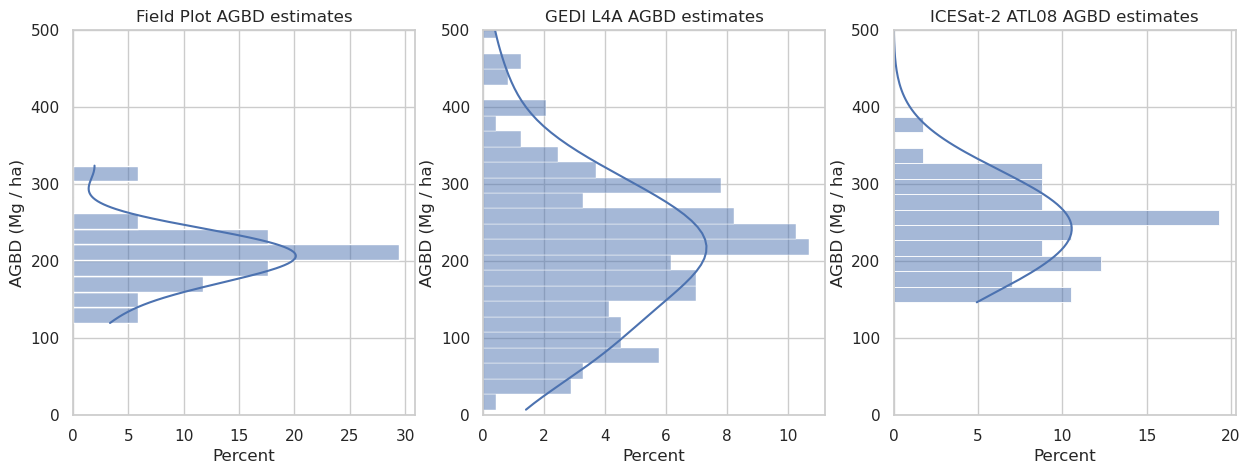

In [21]:
# pandas dataframe
atl08_df2 = pd.DataFrame(list(zip(chm_50,chm_98)), columns=["chm_50", "chm_98"])
# gedi allometry
atl08_df2["AGBD"]= -134.77015686035156 + (6.653591632843018 * atl08_df2.chm_50) + (6.687118053436279 * atl08_df2.chm_98) 
# predictor_offset
atl08_df2["AGBD"] = atl08_df2["AGBD"]+100
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
sns.histplot(ax=ax1, data=total_agb, y="AGBD", binwidth=20, kde=True, stat='percent')
ax1.set(ylabel="AGBD (Mg / ha)", ylim=(0, 500),
       title="Field Plot AGBD estimates")
ax2 = fig.add_subplot(1, 3, 2)
sns.histplot(ax=ax2, data=gedi_gdf[mask], binwidth=20, y="agbd", kde=True, stat='percent') 
ax2.set(ylabel="AGBD (Mg / ha)", ylim=(0, 500),
       title="GEDI L4A AGBD estimates")
ax3 = fig.add_subplot(1, 3, 3)
sns.histplot(ax=ax3, data=atl08_df2, binwidth=20, y="AGBD", kde=True, stat='percent') 
ax3.set(ylabel="AGBD (Mg / ha)", ylim=(0, 500),
       title="ICESat-2 ATL08 AGBD estimates")
plt.show()

### Photon Classification
Photon information is provided in the `signal_photons` group within each ground track. Let’s plot the photon height (`ph_h`) and classification (`classed_pc_flag`) of these four ATL08 files.

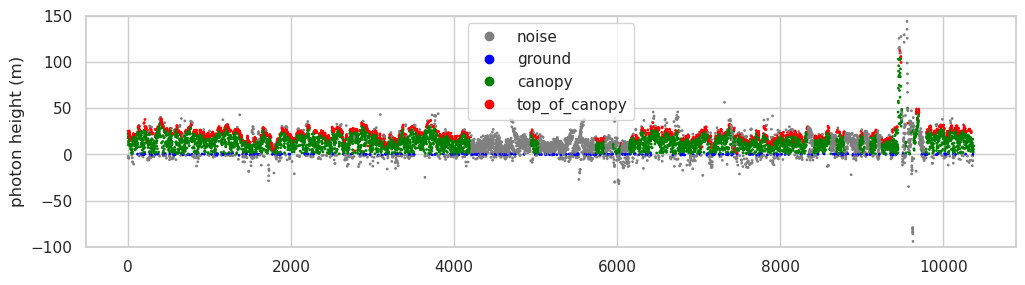

In [22]:
# photon classes
classes = ['noise', 'ground', 'canopy', 'top_of_canopy']   
colors = ListedColormap(['gray','blue','green','red'])
plt.figure(figsize=(12, 3))
scatter = plt.scatter(range(len(ph_h)),ph_h,c=classed_pc_flag, cmap=colors, s=1)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.ylim(-100, 150) 
plt.ylabel("photon height (m)")
plt.show()

## References
```{bibliography}
:style: plain
:filter: docname in docnames
```